# Predicting Hospital Readmission for Diabetes Patients

## Objective
Demonstrate an end-to-end machine learning pipeline to predict whether a patient will be readmitted to a hospital after a diabetes diagnosis using data maintained by UCI detailing 10 years of clinical care at U.S. hospitals and integrated delivery networks.

## Table of Contents
* [Data Loading](#data_loading)
* [Data Cleaning & Preprocessing](#data_cleaning)
* [Exploratory Data Analysis (EDA)](#eda)
* [Feature Engineering](#feature_engineering)
* [Model Training & Evaluation](#model_training)

In [1]:
import io
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import requests

%matplotlib inline

## Data Loading <a class="anchor" id="data_loading"></a>

In [2]:
# URL of the dataset
url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"

try:
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    response.raise_for_status() # raises error for bad HTTP responses

    print("Download successful! Extracting files...")
    zip_file = zipfile.ZipFile(io.BytesIO(response.content)) # open ZIP in memory

    # list the files
    files_list = zip_file.namelist()
    print("Files contained in ZIP:\n", ", ".join(files_list))

    # create a dictionary to store the files
    files = {}

    for file_name in files_list:
        with zip_file.open(file_name) as f:
            files[file_name] = pd.read_csv(f)

    # assign the DataFrames to variables
    df_diabetes = files.get("diabetic_data.csv")
    df_ids = files.get("IDS_mapping.csv")

except requests.exceptions.RequestException as e:
    print(f"Error downloading dataset: {e}")

    # TODO: Possibly comment out the next three lines
    print("Retrieving from local directory...")
    df_diabetes = pd.read_csv("~/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv")
    df_ids = pd.read_csv("~/Downloads/diabetes+130-us+hospitals+for+years+1999-2008/IDS_mapping.csv")

except zipfile.BadZipFile:
    print("Error processing ZIP file")

except OSError as e:
    print(f"Error opening file: {e}")

except KeyError as e:
    print(f"Error retrieving file: {e}")

Download successful! Extracting files...
Files contained in ZIP:
 diabetic_data.csv, IDS_mapping.csv


## Data Cleaning & Preprocessing <a class="anchor" id="data_cleaning"></a>

In [3]:
# prepare the IDs DF for merging
df_ids.dropna(inplace=True)
df_filtered_ids = df_ids[df_ids["admission_type_id"].str.isdigit()].copy()
df_grouped_ids = df_filtered_ids.groupby("admission_type_id")["description"].apply(lambda x: " | ".join(x)).reset_index()

# prepare the diabetes DF for merging
df_diabetes["admission_type_id"] = df_diabetes["admission_type_id"].astype(str)

# merge the DFs
df = df_diabetes.merge(df_grouped_ids, how="left", on="admission_type_id")

In [4]:
# identify columns using a question mark as a null value
question_mark_cols = ", ".join(df.columns[(df == "?").any()])
print("Columns using \"?\" to signify null values:\n", question_mark_cols)

# replace "?" rows with NaN
df.where(df != "?", np.nan, inplace=True)

Columns using "?" to signify null values:
 race, weight, payer_code, medical_specialty, diag_1, diag_2, diag_3


In [15]:
def display_missing_value_columns(df):
    """Generates a DataFrame analyzing columns' null values.

    Args:
        df (pd.DataFrame): A dataset.

    Returns:
        pd.DataFrame: A DataFrame containing null statistics.
    """

    # get columns and their missing value counts
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0].reset_index()

    # rename the columns and calculate the percentage of nulls
    missing_values.columns = ["column_name", "null_count"]
    missing_values["null_perc"] = missing_values["null_count"] / df.shape[0]

    # sort the values
    missing_values.sort_values(by="null_perc", ascending=False, inplace=True)

    return missing_values

In [16]:
# create a DF showing missing value statistics
display_missing_value_columns(df)

,column_name,null_count,null_perc
0,race,2273,0.022336
3,diag_3,1423,0.013983
6,disease_class_3,1423,0.013983
2,diag_2,358,0.003518
5,disease_class_2,358,0.003518
1,diag_1,21,0.000206
4,disease_class_1,21,0.000206


In [ ]:
# drop columns with 30% or more values missing
non_na_vals = df.shape[0] - (0.3 * df.shape[0])
df.dropna(thresh=non_na_vals, axis=1, inplace=True)

In [7]:
def map_icd9_to_category(code):
    """Maps ICD-9 codes to disease categories.

    Args:
        code: A string value representing an ICD-9 code.
    Returns:
        category: A string value representing a disease classification.
    """

    try:
        code = str(code).strip()
        if code.startswith("250"):
            category =  "Diabetes-Related"
        elif code.startswith("E"):
            category =  "Supplementary Classification of External Causes of Injury and Poisoning"
        elif code.startswith("V"):
            category =  "Supplementary Classification of Factors influencing Health Status and Contact with Health Services"

        code = int(float(code))
        if 1 <= code <= 139:
            category =  "Infectious and Parasitic Diseases"
        elif 140 <= code <= 239:
            category =  "Neoplasms"
        elif 240 <= code <= 279:
            category =  "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders"
        elif 280 <= code <= 289:
            category =  "Diseases of the Blood and Blood-forming Organs"
        elif 290 <= code <= 319:
            category =  "Mental Disorders"
        elif 320 <= code <= 389:
            category =  "Diseases of the Nervous System and Sense Organs"
        elif 390 <= code <= 459:
            category =  "Diseases of the Circulatory System"
        elif 460 <= code <= 519:
            category =  "Diseases of the Respiratory System"
        elif 520 <= code <= 579:
            category =  "Diseases of the Digestive System"
        elif 580 <= code <= 629:
            category =  "Diseases of the Genitourinary System"
        elif 630 <= code <= 679:
            category =  "Complications of Pregnancy, Childbirth, and the Puerperium"
        elif 680 <= code <= 709:
            category =  "Diseases of the Skin and Subcutaneous Tissue"
        elif 710 <= code <= 739:
            category =  "Diseases of the Musculoskeletal System and Connective Tissue"
        elif 740 <= code <= 759:
            category =  "Congenital Anomalies"
        elif 760 <= code <= 779:
            category =  "Certain Conditions originating in the Perinatal Period"
        elif 780 <= code <= 799:
            category =  "Symptoms, Signs and Ill-defined Conditions"
        elif 800 <= code <= 999:
            category =  "Injury and Poisoning"
        else:
            category =  "Other"

    except:
        category =  "Other"

    return category

In [8]:
# convert ICD-9 codes to disease categories
df[["disease_class_1", "disease_class_2", "disease_class_3"]] = df[["diag_1", "diag_2", "diag_3"]].apply(lambda col: col.map(map_icd9_to_category, na_action="ignore"))

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In [ ]:
# look at descriptive statistics for numeric columns
numeric_cols = df.select_dtypes(include="number").columns
numeric_cols = numeric_cols[~numeric_cols.str.contains(r"_(?:id|nbr)", case=False, regex=True)]
df[numeric_cols].describe()

In [9]:
def plot_numeric_distributions(df):
    """Generates a grid of boxplots and histograms for numeric columns.

    Args:
        df (pd.DataFrame): A dataset with numeric data.
    """

    # identify numeric columns and remove ID columns
    numeric_cols = df.select_dtypes(include='number').columns
    numeric_cols = sorted(numeric_cols[~numeric_cols.str.contains(r"_(?:id|nbr)\b", case=False, regex=True)])

    # get the number of numeric columns
    num_cols = len(numeric_cols)

    # create a figure and set of subplots
    fig, axes = plt.subplots(num_cols, 2, figsize=(10, 5 * num_cols))

    # create a side-by-side boxplot and histogram for each row
    for i, col in enumerate(numeric_cols):
        sns.boxplot(data=df, x=col, color="mediumvioletred", ax=axes[i, 0])
        axes[i, 0].set_title(f"Boxplot of {col}")

        sns.histplot(data=df, x=col, color="lightcoral", ax=axes[i, 1])
        axes[i, 1].set_title(f"Histogram of {col}")

    # prevent overlap and display figure
    plt.tight_layout()
    plt.show()


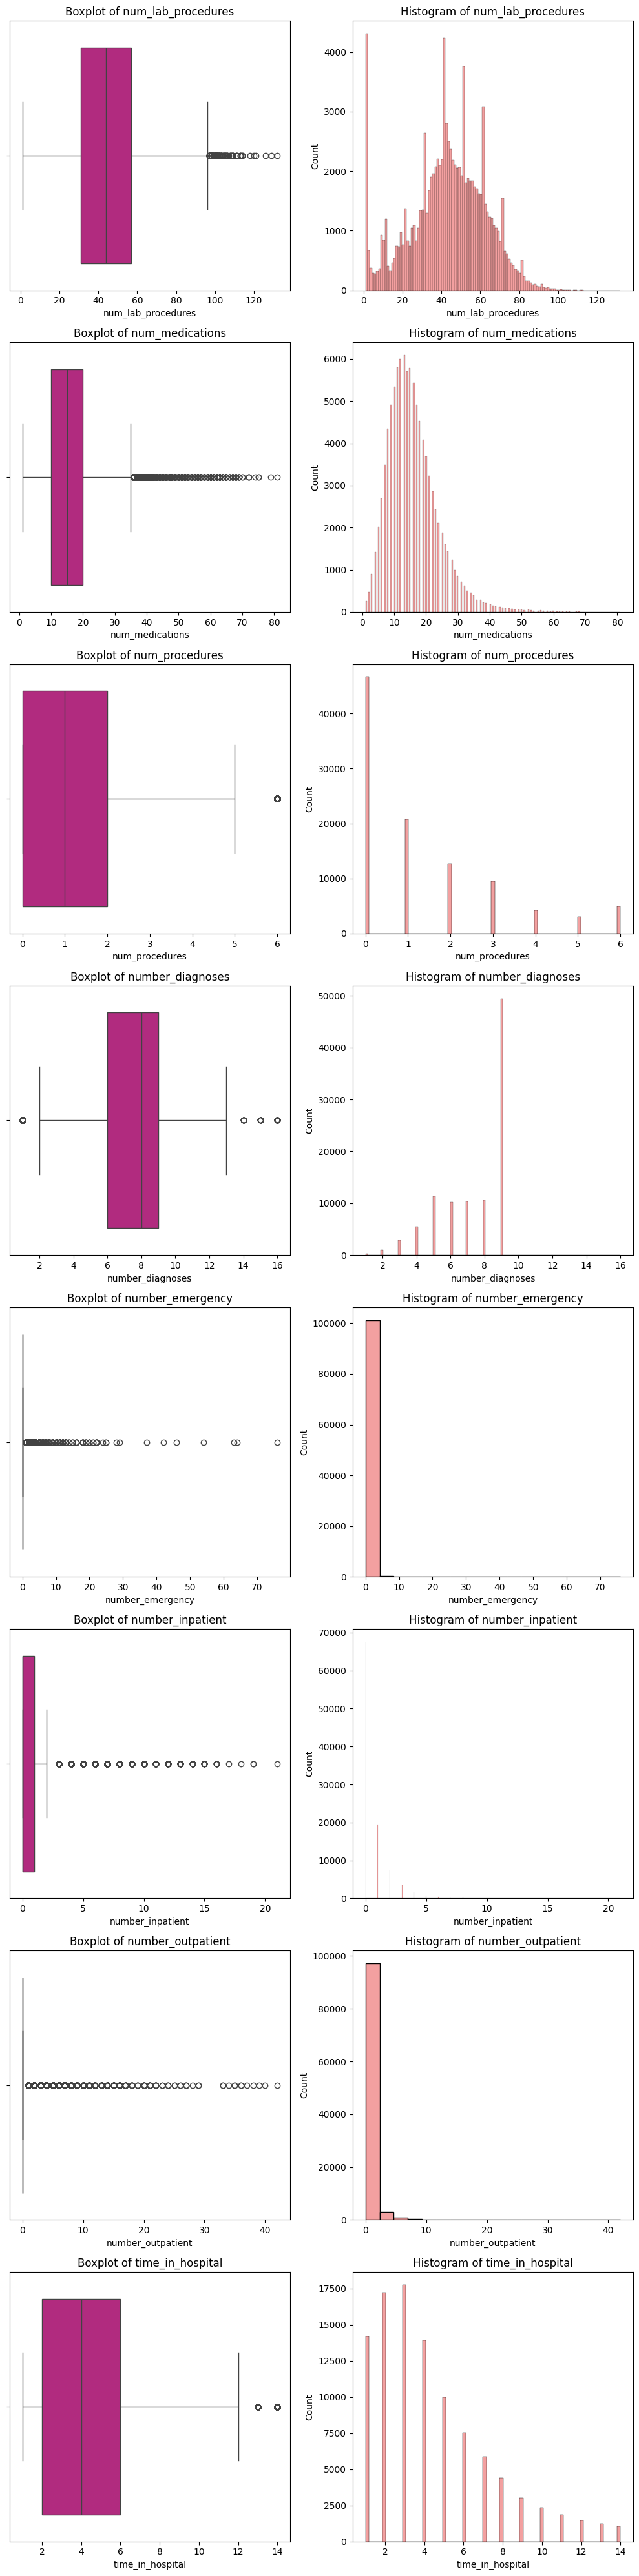

In [27]:
# analyze the distributions in the numeric data
plot_numeric_distributions(df)

In [20]:
def display_skewness_columns(df):
    """Generates a DataFrame analyzing columns' skewness.

    Args:
        df (pd.DataFrame): A dataset containing numeric data.

    Returns:
        pd.DataFrame: A DataFrame containing skewness values.
    """

    # check for skewness and rename columns
    skewness = df.select_dtypes(include="number").skew().reset_index()
    skewness.columns = ["column_name", "value"]

    # filter out identifier columns
    skewness = skewness[~skewness["column_name"].str.contains(r"_(?:id|nbr)\b", case=False, regex=True)]

    # categorize the skewness
    conditions = [skewness["value"].abs().between(0.5, 1), skewness["value"].abs() > 1]
    choices = ["Moderate", "High"]
    skewness["skew_category"] = np.select(conditions, choices, default="Symmetric")

    # sort the values
    skewness.sort_values(by="value", ascending=False, inplace=True)

    return skewness

In [21]:
# create a DF showing skewness
display_skewness_columns(df)

,column_name,value,skew_category
9,number_emergency,22.855582,High
8,number_outpatient,8.832959,High
10,number_inpatient,3.614139,High
7,num_medications,1.326672,High
6,num_procedures,1.316415,High
4,time_in_hospital,1.133999,High
5,num_lab_procedures,-0.236544,Symmetric
11,number_diagnoses,-0.876746,Moderate


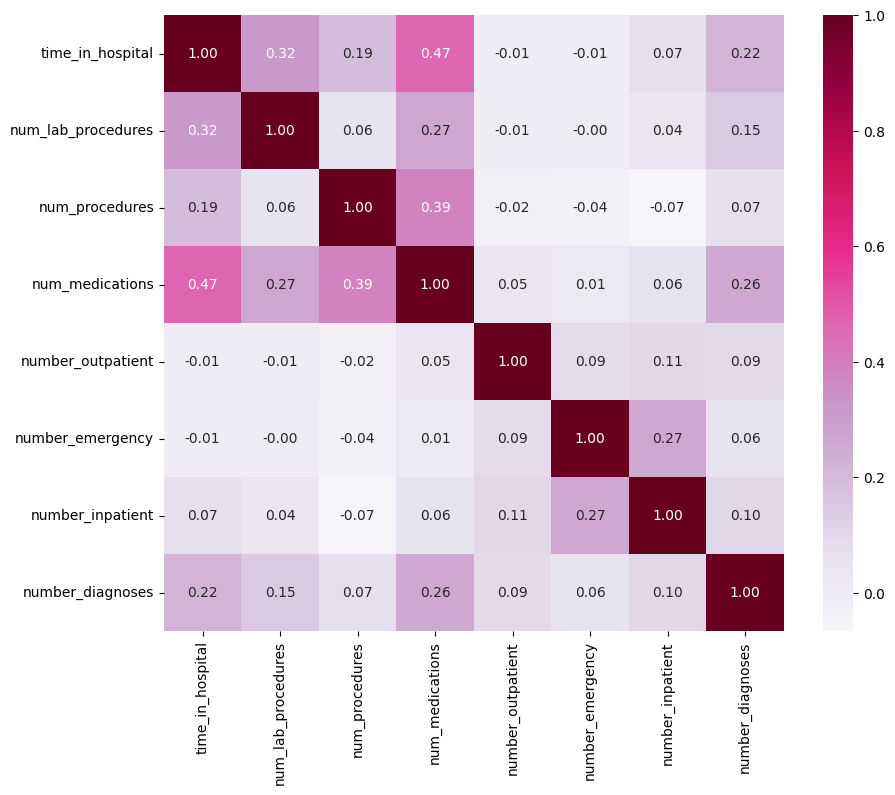

In [77]:
# analyze the strength of relationships among numeric columns
plt.figure(figsize=(10, 8))
corr_df = df.filter(regex=r"^(?!.*_(?:id|nbr)$)").corr(numeric_only=True)
sns.heatmap(corr_df, cmap="PuRd", annot=True, fmt=".2f")
plt.show()